# Machine Learning Engineer Nanodegree

## Capstone Project

## Kaggle: Porto Seguro's Safe Driver Prediction

This project is based on Porto Seguro's Safe Driver Prediction competition on Kaggle. [Porto Seguro](https://www.portoseguro.com.br) is one of the largest homeowner and auto insurance companies in Brazil. 

Porto Seguro is known to have used machine learning for the past 20 years but is looking for new ways to improve its prediction models. Inaccuracies in predicting insurance claims raises the cost of insurance for good drivers and reduces it for bad drivers. Thus an accurate model would increase the fairness of insurance costs.

The competition can be found here: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

The dataset used for this project can be downloaded directly from Kaggle in the link above.

## Data Exploration

In [1]:
# Import necessary libraries
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

The data is provided in .csv format. We'll be loading it with pandas' read_csv method. The training and testing sets will be loaded into separate dataframes.

In [2]:
# Load data
train_path = 'data/train.csv'
test_path = 'data/test.csv'

try:
    train = pd.read_csv(train_path, index_col=0)
    train_rows = train.shape[0] # Number of rows
    train_cols = train.shape[1] # Number of columns
    print("Porto training dataset has {0} rows and {1} columns".format(train_rows, train_cols))
    
    test = pd.read_csv(test_path, index_col=0)
    test_rows = test.shape[0] # Number of rows
    test_cols = test.shape[1] # Number of columns
    print("Porto testing dataset has {0} rows and {1} columns".format(test_rows, test_cols))
    
except:
    print("Porto datasets could not be loaded.")

Porto training dataset has 595212 rows and 58 columns
Porto testing dataset has 892816 rows and 57 columns


The testing set will be used to test the models on Kaggle. It has one column less because the target variable is stored on Kaggle's servers. 

For local evaluation while training we will be using cross-validation. It is a technique to evaluate models by dividing the set into a number of equal size subsamples. In K-fold cross-validation the model is trained on k-1 folds of the training data and validated on the last fold. This is repeated for each of the folds and the performance measure is the average of the values computed in each loop.

To get a quick intuition on the structure of the dataset it is often useful to take a look at the first few rows:

In [3]:
train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
test.columns

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

First of all, we have a target column and we want to create a model that is able to accurately predict the target variable. This means that the current project is a supervised learning problem. 

The names of the columns are not very inuitive. The creator of the competition states that he can't share the real meanings of the variables but explains that:

*"Ind" is related to individual or driver, "reg" is related to region, "car" is related to car itself and "calc" is a calculated feature.*

*The features and rows are not time dependent, so "ps_ind_01" and "ps_ind_02" are just labels to hide real names.*

This explanation can be found in the following post:

https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/40222

It is also important to note that feature names that include the postfix "bin" are binary features, if they include "cat" they are categorical features and features without these two are either continuous or ordinal. This information can be found in the data description of the competition.

Next we check if there are any missing values in the dataset.

In [5]:
train.isnull().any().any()

False

The check shows that there are no missing values, but the data description offered by Kaggle states that for the whole dataset values of -1 indicate that a feature was missing from the observation. 

Curiously, several people on the Kaggle discussion forums have stated that they get better scores by not replacing -1 with. This might indicate that the missing values in some way also offer some kind of information that can be useful for prediction. 

For example, and this is pure personal speculation, not caring about filing certain documents could be correlated with reckless driving. It could also be that people with more missing values are part of a different group in which accidents are more common and the missing values are due to different policies or some other characteristic particular to that group.

### Target

Before diving into the different features, it can be useful to take a look at the target variable:

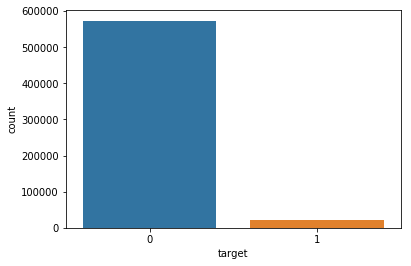

In [6]:
# Counts number of instances in each class
sns.countplot(x="target", data=train)

In [7]:
# Prints number of clients and percentage of each class
num_no_claims = train["target"].value_counts()[0]
num_claims = train["target"].value_counts()[1]
total_clients = num_no_claims + num_claims

print("There are {} clients who have filed claims".format(num_claims))
print("This is equal to {} % of the dataset".format(round(num_claims/total_clients*100, 2)))
print()
print("There are {} clients who have not filed claims".format(num_no_claims))
print("This is equal to {} % of the dataset".format(round(num_no_claims/total_clients*100, 2)))


There are 21694 clients who have filed claims
This is equal to 3.64 % of the dataset

There are 573518 clients who have not filed claims
This is equal to 96.36 % of the dataset


As seen above the target data it is binary. A value of 0 means that they didn't file a claim during the period the data was collected and a value of 1 means that a claim was filed by a client. 

It is also noteworthy that the target data is highly imbalanced, with just under 4% of the clients filing claims. 

Imbalanced data is a recurring problem, often in classification problems where classes are not represented equally. Jason Brownlee offers some tips to work with imbalanced data on this link: https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

This is important because it might cause misleading results. Given that this is a supervised classification problem, it is relatively easy to calculate the accuracy with how many of the drivers were classified correctly. Still, it is not the best metric because, with less than 4% filing a claim, a very good accuracy could be achieved by just classifying every driver as “not filing a claim in the next year”. This is called the *accuracy paradox*. 

One of the first tips is to change the **performance metric**. The F-beta Score and Normalized Gini metric were chosen for this project.

Another tip is **sampling** the dataset to make the classes more balanced. Two techniques are over-sampling by adding copies of instances from the under-represented class, and under-sampling by deleting instances from the over-represented class.


### Sampling

The sample dataset has 46694 rows

There are 21694 clients who have filed claims
This is equal to 46.46 % of the dataset

There are 25000 clients who have not filed claims
This is equal to 53.54 % of the dataset


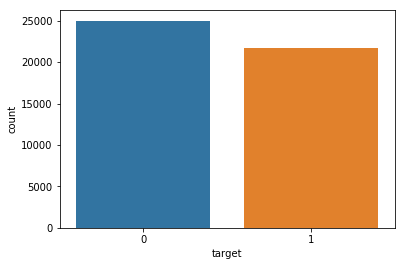

In [8]:
# Selects a sample of the over-represented class effectively deleting instances
# of the class
sample_no_claims = train[train['target'] == 0].sample(n=25000)

# We keep all the instances of the under-represented class
claims = train[train['target'] == 1] 

sample_train = pd.concat([sample_no_claims, claims], axis = 0)

# Prints number of clients and percentage of each class with a countplot
sns.countplot(x="target", data=sample_train)
print('The sample dataset has {} rows'.format(sample_train.shape[0]))
print()

s_num_no_claims = sample_train["target"].value_counts()[0]
s_num_claims = sample_train["target"].value_counts()[1]
total_clients = s_num_no_claims + s_num_claims

print("There are {} clients who have filed claims".format(s_num_claims))
print("This is equal to {} % of the dataset".format(round(s_num_claims/total_clients*100, 2)))
print()
print("There are {} clients who have not filed claims".format(s_num_no_claims))
print("This is equal to {} % of the dataset".format(round(s_num_no_claims/total_clients*100, 2)))


A more balanced sample of the dataset was created in the sample_train variable. It has a total of 46.694 rows.

### Features

Next we start exploring the features in more depth.

As mentioned in the beginning, the features are grouped according to similarity of the source (car, driver, region or calculated) and according to type (binary, categorical with more than two classes or continuous). 

Next we create a dictionary which we can use to easier analyze the features according to group or type.

In [9]:
feature_names = ['ind', 'car', 'reg', 'calc']
feature_types = ['bin', 'cat', 'cont']
feature_dict = {}


# This loop groups the columns only according to 
# the data type (binary, categorical or continuous) 
for type_ in feature_types:
    for feature in feature_names:
        feature_dict[feature + '_' + type_] = []
        feature_dict[type_ + '_cols'] = []
        
# This loop groups the columns according to the data type (binary, 
# categorical or continuous) and according to its group (driver, car, region
# or calculated)
for feature in feature_names:
    feature_dict[feature + '_cols'] = [col for col in train.columns if feature in col]
    
    for col in feature_dict[feature + '_cols']:
        if 'cat' in col:
            feature_dict[feature + '_cat'].append(col)
            feature_dict['cat_cols'].append(col)
        elif 'bin' in col:
            feature_dict[feature + '_bin'].append(col)
            feature_dict['bin_cols'].append(col)
        else:
            feature_dict[feature + '_cont'].append(col)
            feature_dict['cont_cols'].append(col)

Some of the combinations might not contain any columns, so we can delete them from our feature grouping dictionary:

In [10]:
empty_cols = []
for key, item in feature_dict.items():
    if len(item) == 0:
        print(key)
        empty_cols.append(key)
        
for key in empty_cols:
    del feature_dict[key]

car_bin
reg_bin
reg_cat
calc_cat


In [11]:
for key, item in feature_dict.items():
    print(key, ':', len(item))

ind_bin : 11
bin_cols : 17
calc_bin : 6
ind_cat : 3
cat_cols : 14
car_cat : 11
ind_cont : 4
cont_cols : 26
car_cont : 5
reg_cont : 3
calc_cont : 14
ind_cols : 18
car_cols : 16
reg_cols : 3
calc_cols : 20


At this point we can start taking a closer look at each type of features

In [12]:
train[feature_dict['ind_cont']].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15
count,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922
std,1.983789,2.699902,0.127545,3.546042
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000
50%,1.000000,4.000000,0.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000
max,7.000000,11.000000,4.000000,13.000000


In [13]:
train[feature_dict['cont_cols']].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_reg_01,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,0.379945,0.813265,0.276256,3.065899,0.610991,...,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,0.058327,0.224588,0.357154,0.731366,0.287643,...,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,0.316228,0.670867,0.333167,2.828427,0.400000,...,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,0.374166,0.765811,0.368782,3.316625,0.700000,...,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,0.400000,0.906190,0.396485,3.605551,0.900000,...,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,1.264911,3.720626,0.636396,3.741657,0.900000,...,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


For example, we can use the dictionary to make a heatmap showing correlation between the continuous features:

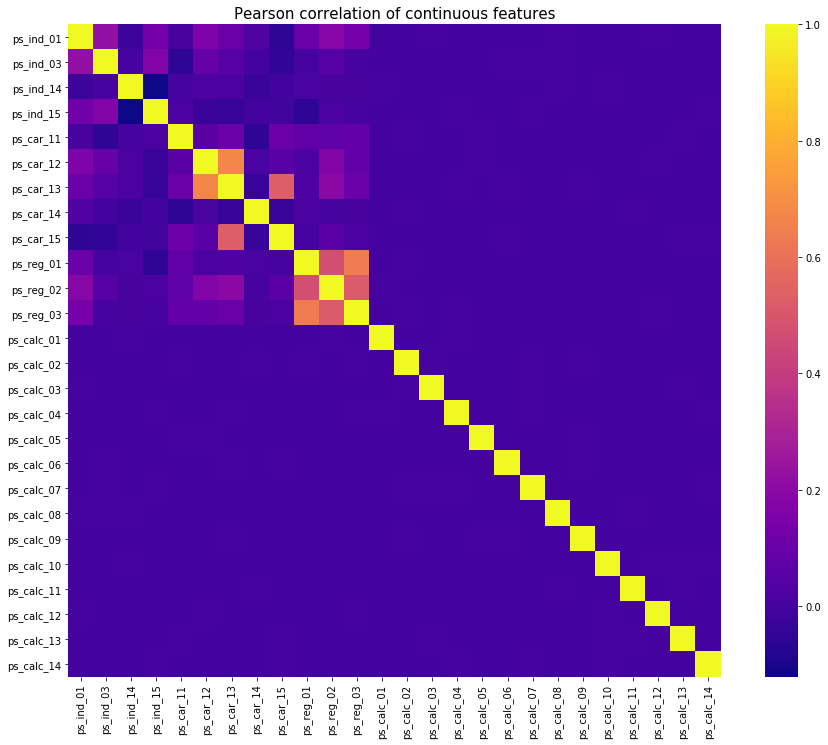

In [14]:
train_cont = train[feature_dict['cont_cols']] # Chooses continuous features

plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', size=15)
sns.heatmap(train_cont.corr(), vmax=1.0, square=True,
           cmap='plasma', annot=False, annot_kws={"size": 13})

Most of the features have very low to no correlation, especially the calculated features. Some features within certain groups do show some degree of correlation with other features in the same group. 

For example, within the 'car' group the features ps_car_12 and ps_car_13 have a correlation of around 0.7 and the features ps_car_13 and ps_car_15 have a correlation of approximately 0.5. Also, all three continuous features related to region show correlation values between 0.45 to 0.65. 

Intuitively it seems normal for similar features to have a certain degree of correlation. For classification purposes a low correlation between features can be interesting because they are all offering different information which can be used for the classifier.

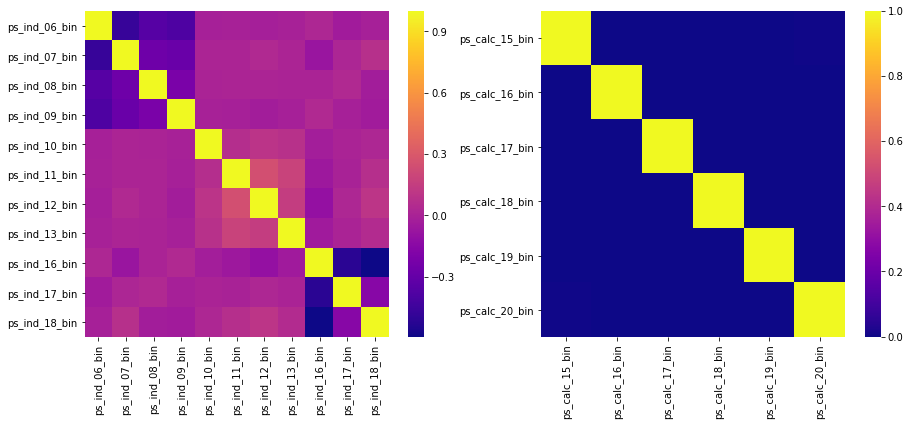

In [15]:
fig, axes = plt.subplots(1,2,figsize=(15,6))
plt.xticks(rotation='vertical')
sns.heatmap(train[feature_dict['ind_bin']].corr(),ax=axes[0],cmap="plasma")
sns.heatmap(train[feature_dict['calc_bin']].corr(),ax=axes[1],cmap="plasma")

These heatmaps on binary features separated by groups (the 'car' and 'reg' don't have binary features) show the same trend as the heatmap above. The calculated features have practically no correlation. The features related to the driver have a certain degree of correlation but the highest seems to be around 0.5. 

Instead of plotting heatmaps of all the features we can graph some of the distributions. A scatter matrix of different features is a great way to have a better understanding of the data. Next we'll be focusing on the continuous features by groups.

Pairplot of continuous features in 'ind' group


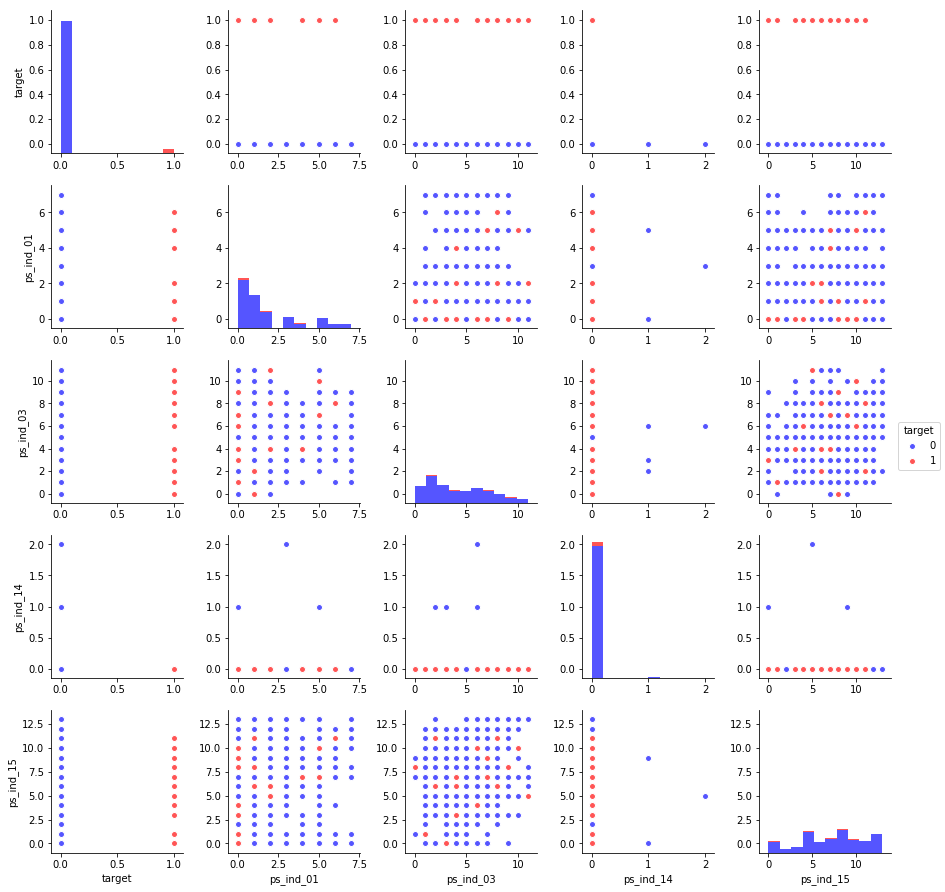

In [16]:
print("Pairplot of continuous features in 'ind' group")
tmp = pd.concat([train['target'], train[feature_dict['ind_cont']]], axis=1)
sns.pairplot(tmp.sample(n=500), hue='target', palette='seismic')

These graphs are useful to better understand the distributions of the features, although this group doesn't show any clear difference between drivers that do or don't file claims. 

Pairplot of continuous features in 'car' group


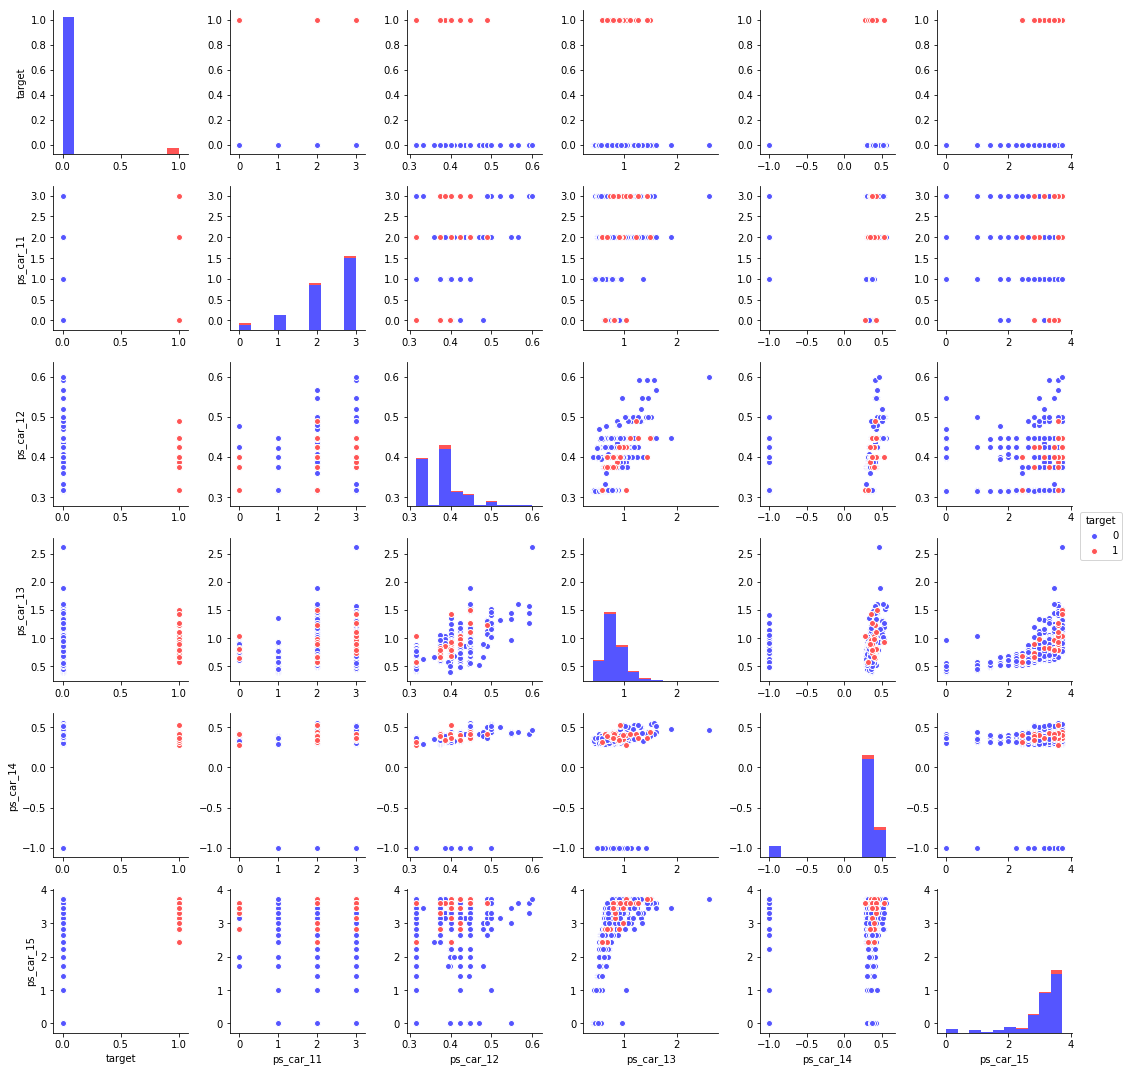

In [17]:
print("Pairplot of continuous features in 'car' group")
tmp = pd.concat([train['target'], train[feature_dict['car_cont']]], axis=1)
sns.pairplot(tmp.sample(n=500), hue='target', palette='seismic')

These plots offer some initial information that still would have to be validated. At first glance, drivers that filed a claim seem to cluster around certain values in some plots. For example, higher values of the 'ps_car_15' feature seems visually to have more drivers that file claims than lower values of that feature. 

Still, as mentioned this is just something to look into and could simply be caused by the sparsity of the target=1 values. All drivers seem to have higher 'ps_car_15' values and a larger sample of no-claim drivers would logically also produce more outliers from that class. This would make the graph visually misleading.

Here is a close-up of the plot between the 'ps_car_14' and 'ps_car_15' features:

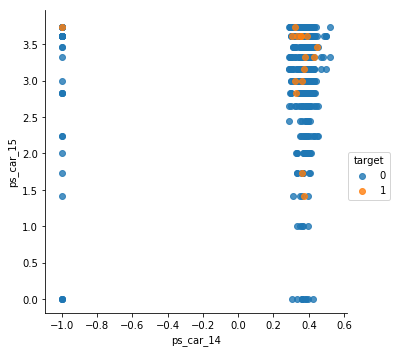

In [18]:
tmp = train.sample(n=500)
sns.lmplot(x='ps_car_14', y='ps_car_15', data=tmp, hue='target', fit_reg=False)

One thing that can be seen in the pairplot graph is that the data is not normally distributed. In these cases it can help to apply non-linear scaling. The Box-Cox test is a way to do this that calculates the best power transformation of the data to reduce skewness. 

$$x({\lambda}) = \begin{cases}\frac{x^{\lambda}-1}{\lambda} & \lambda \neq 0\\log(x) & \lambda = 0\end{cases}$$

However, the Boxcox transformation above has a log term which will probably cause problems with the "-1" label used for missing values. To apply this method all the values have to be shifted. 

For categorical data we can use sci-kit learn's LabelEncoder which can be used to normalize labels.

In [19]:
# We can keep some feature to make a visual comparison
example = train[['target', 'ps_car_13', 'ps_car_14']].copy()

# Import necessary preprocessing and statistical functions
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy import stats

# As stated above, the Box-Cox test transforms data to reduce skewness.
# The MinMaxScaler scales then scales each feature to a given range (predetermined is 0 to 1)
mms = MinMaxScaler() 
for col in feature_dict['cont_cols']:
    shift = np.abs(np.floor(min(train[col])))
    train[col] = mms.fit_transform((stats.boxcox(train[col] + shift + 1)[0]).reshape(-1,1))
    
    shift = np.abs(np.floor(min(sample_train[col])))
    sample_train[col] = mms.fit_transform((stats.boxcox(sample_train[col] + shift + 1)[0]).reshape(-1,1))
    
    shift = np.abs(np.floor(min(test[col])))
    test[col] = mms.fit_transform((stats.boxcox(test[col] + shift + 1)[0]).reshape(-1,1))
        
le = LabelEncoder() # Used to normalize categorical labels
for col in feature_dict['cat_cols']:
    train[col] = le.fit_transform(train[col])
    
    sample_train[col] = le.fit_transform(sample_train[col])
    
    test[col] = le.fit_transform(test[col])

To visualize the transform we can print the original scatter plot between the features 'ps_car_13' and 'ps_car_14':

Pairplot of continuous features in 'car' group


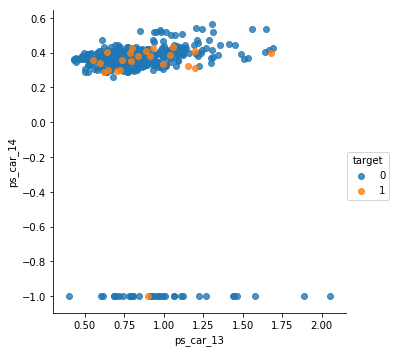

In [20]:
print("Pairplot of continuous features in 'car' group")
sns.lmplot(x='ps_car_13', y='ps_car_14', data=example.sample(n=500), hue='target', fit_reg=False)

The graph above can be compared to a scatter plot with the transformed features:

Pairplot of continuous features in 'car' group


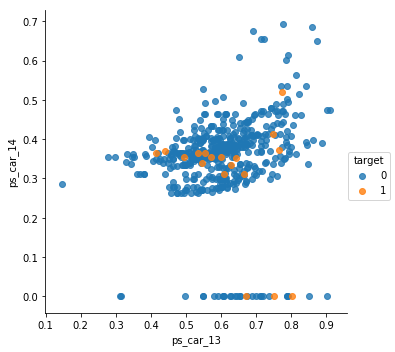

In [21]:
print("Pairplot of continuous features in 'car' group")
tmp = train.sample(n=500)
sns.lmplot(x='ps_car_13', y='ps_car_14', data=tmp, hue='target', fit_reg=False)

## Evaluation metric

Before training the model we should also select the evaluation metric. In this case, we will be using the Normalized Gini Coefficient as our principal evaluation metric.  

In [22]:
# We use the Python implementation from the Gini coefficient discussion with code samples on Kaggle
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703

def gini(actual, pred):
    assert (len(actual) == len(pred)) # Checks that target variable and predictions have the same length 
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

The evaluation metric used by the competition is the normalized Gini coefficient. The Gini coefficient is best known for and is usually used to assess inequality. According to [EFL Global](https://www.eflglobal.com/every-lender-has-a-gini-coefficient-so-what-exactly-is-it/), the Gini Coefficient is also often used to evaluate the predictive power of credit scoring tools.

A good credit score is supposed to assign high scores to safe applicants and low scores to riskier applicants. The Gini Coefficient is used to evaluate how well it does that. It is a scale of predictive power from 0 to 1 in which a lower score means less predictive power and is equivalent to a random prediction, like using a coin toss. A Gini Coefficient of 1 indicates perfect predictive power and for credit scores it would perfectly identify who will repay and who will default.

Having this in mind, it makes sense for the Gini Coefficient to be used in our context of insurance claims. Instead of a credit score we are almost calculating a "safe-driving score" which can be used to evaluate how likely it is for a driver to file a claim or not in the next year (instead of paying vs defaulting in the credit score example).

This evaluation metric is among the most usual for predictive models so before moving on we can show how it works based on an [explanation by kilian on Kaggle](https://www.kaggle.com/batzner/gini-coefficient-an-intuitive-explanation)

Calculating using the 'gini' and 'gini_normalized' functions we get:
Gini= 0.210, Max. Gini= 0.267, Normalized Gini= 0.786


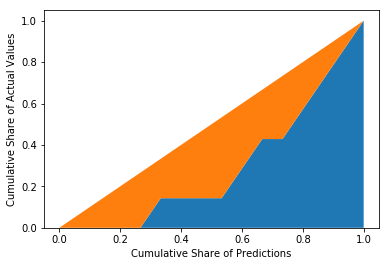

This graph compares the 45° line (random guessing) to the cumulative sum of our predictions 
which corresponds to the Lorenz Curve.

Integrating the curve function we can calculate the orange area which is equal to 
the Gini score calculated above
Orange Area: 0.210

The same can be done to get the maximum possible Gini Coefficient. The actual values are used as
predictions to construct the cumulative score line


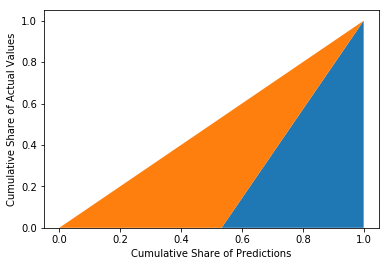

The area of the orange area also corresponds to the maximum Gini calculated above.
Orange Area: 0.267


In [23]:
from scipy import interpolate, integrate 

predictions = [0.9, 0.3, 0.8, 0.75, 0.65, 0.6, 0.78, 0.7, 0.05, 0.4, 0.4, 0.05, 0.5, 0.1, 0.1]
actual = [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

gini_predictions = gini(actual, predictions)
gini_max = gini(actual, actual)
ngini = gini_normalized(actual, predictions)

# Sort the actual values by the predictions
data = zip(actual, predictions)
sorted_data = sorted(data, key=lambda d: d[1])
sorted_actual = [d[0] for d in sorted_data]

# Sum up the actual values
cumulative_actual = np.cumsum(sorted_actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1)

print("Calculating using the 'gini' and 'gini_normalized' functions we get:")
print('Gini= %.3f, Max. Gini= %.3f, Normalized Gini= %.3f' % (gini_predictions, gini_max, ngini))

cumulative_actual_shares = cumulative_actual / sum(actual)
cumulative_index_shares = cumulative_index / len(predictions)

# Add (0, 0) to the plot
x_values = [0] + list(cumulative_index_shares)
y_values = [0] + list(cumulative_actual_shares)

# Display the 45° line stacked on top of the y values
diagonal = [x - y for (x, y) in zip(x_values, y_values)]

plt.stackplot(x_values, y_values, diagonal)
plt.xlabel('Cumulative Share of Predictions')
plt.ylabel('Cumulative Share of Actual Values')
plt.show()
print("""This graph compares the 45° line (random guessing) to the cumulative sum of our predictions 
which corresponds to the Lorenz Curve.""")

fy = interpolate.interp1d(x_values, y_values)
blue_area, _ = integrate.quad(fy, 0, 1, points=x_values)
orange_area = 0.5 - blue_area
print("""\nIntegrating the curve function we can calculate the orange area which is equal to 
the Gini score calculated above""")
print('Orange Area: %.3f' % orange_area)


print("""\nThe same can be done to get the maximum possible Gini Coefficient. The actual values are used as
predictions to construct the cumulative score line""")
cumulative_actual_shares_perfect = np.cumsum(sorted(actual)) / sum(actual)
y_values_perfect = [0] + list(cumulative_actual_shares_perfect)

# Display the 45° line stacked on top of the y values
diagonal = [x - y for (x, y) in zip(x_values, y_values_perfect)]

plt.stackplot(x_values, y_values_perfect, diagonal)
plt.xlabel('Cumulative Share of Predictions')
plt.ylabel('Cumulative Share of Actual Values')
plt.show()

# Integrate the the curve function
fy = interpolate.interp1d(x_values, y_values_perfect)
blue_area, _ = integrate.quad(fy, 0, 1, points=x_values)
orange_area = 0.5 - blue_area
print('The area of the orange area also corresponds to the maximum Gini calculated above.')
print('Orange Area: %.3f' % orange_area)

The explanation above shows how the Gini Coefficient can be understood as the are between the Lorenz Curve and the 45° line. Still, we are interested in the Normalized Gini Coefficient. We get this score by dividing the Gini Coeffcient by the Maximum Gini Coefficient (calculated with the actual values as predictions). This outputs a normalized value between 0 and 1 which we can use to compare models.

Remembering from above:
Gini = 0.210
Max. Gini = 0.267
Normalized Gini = 0.786

Dividing the Gini by the Maximum Gini:
0.210 / 0.267 = 0.786

## Training
### Benchmark model

We will start by establishing a Naïve model as our benchmark. 

In [24]:
TP = float(np.sum(train['target'])) # True positives - Sum of positive values in naive case
TN = 0 # True negatives - No predicted negatives in the naive case
FN = 0 # False Negatives - No predicted negatives in the naive case
FP = train['target'].count() - TP # False positives - Specific to this naive case (Total count - True Positives)
accuracy = TP / train['target'].count()
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# Here we calculate the F-Beta score with a beta of 1.5 to focus on recall, and the Normalized Gini
beta = 1.5
fscore = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
n_gini = gini_normalized(train['target'], train['target']*0+1)

# Print the results 
print("Naive Predictor: Accuracy score= {:.4f}, F-score= {:.4f}, Normalized Gini= {:.4f}".format(accuracy, fscore, n_gini))

Naive Predictor: Accuracy score= 0.0364, F-score= 0.1095, Normalized Gini= 0.0006


As expected, the Naïve model has very low predictive power in terms of the Normalized Gini. 

The accuracy score is very low because we calculated a positive prediction for all cases. We could have an accuracy of practically 96% by just inversing the calculation and assigning a negative prediction to all the values. We won't be using the accuracy from here on.

The F-Beta is used as a secondary evaluation metric because it takes into account precision and recall. In this case a beta of 1.5 is used because it can be important for the insurance company to have better recall. In other words, it is important to evaluate out of the drivers that did file a claim how many were classified as such, to better adjust the insurance fees.

### Submit function

In order to evaluate the model with the test set we have to output the predictions into a file which can be uploaded unto the platform. The following function takes as input the test dataset as a pandas dataframe, a trained model and the desired file name as a string. It outputs the predictions of the test set as a .csv file.

In [25]:
def submit_file(test, model, file_name, val=False):
    '''
    Function to create a file with predictions of test set to submit on Kaggle.

    Input: Test dataset as a pandas dataframe, trained model and desired file name as string  
    Output: Predictions of test set as a .csv file
    '''
    
    sub = pd.DataFrame()
    sub['id'] = test.index
    if not val:
        sub['target'] = model.predict_proba(test)[:,1]
    else:
        sub['target'] = model.predict_proba(test.values)[:,1]
    sub.to_csv(file_name + '.csv', index=False)

### Logistic regression

***What is it?***

Logistic regression is a classification algorithm often used for predictive analysis and tries to explain the relationship between one dependent binary variable and one or more independent variables. A short explanation [posted on Analytics Vidhya](https://www.analyticsvidhya.com/blog/2015/11/beginners-guide-on-logistic-regression-in-r/) is that "it predicts the probability of ocurrence of an event by fitting data to a logit function".

A real-world example for logistic regression could be as a predictor for wether a patient has a disease, like diabetes, or not, based on certain characteristics of the patient like age, body mass index, sex, results tests, etc.

***Strengths of the model***

Logistic regression does not make some of the key assumptions of linear regression and general linear models in terms of, for example, linearity, normality, homoscedasticity, and measurement level. It works with relationships that are not linear because it applies a non-linear log transformation to the predicted odds ratio. It is also popular because its results are relatively easy to interpret. The estimated regression coefficients can be back-transformed off of a log scale to interpret the conditional effects of each feature.

***Weaknesses of the model***

Still, as every model, it has its trade-offs and weaknesses. Logistic regression is a classification model for discrete, binary problems. In order to predecit multiple classes a scheme like one-vs-rest (OvR) has to be used. High correlation variables and outliers can make the model perform poorly. It sometimes needs large datasets because maximum likelihood estimates are less powerful than the ordinary least squares used for linear regression.

***Fit for this problem***

Logistic regression works well when there is a single decision boundary, which can be beneficial in a problem with binary labels like this one. With a little over 46.694 records in the training example it seems like the dataset is large enough for the model. Some statisticians recommend at least 10-30 cases for each parameter to be estimated (source: http://www.statisticssolutions.com/assumptions-of-logistic-regression).

(Sources: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html, http://www.statisticssolutions.com/what-is-logistic-regression/, http://www.statisticssolutions.com/what-is-logistic-regression, http://www.statisticssolutions.com/assumptions-of-logistic-regression/)

In [26]:
from sklearn.metrics import fbeta_score
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import StratifiedKFold # For cross-validation

## 5 fold CV
k = 5
cv = StratifiedKFold(n_splits=k, random_state=25, shuffle=True)
ginis = [] # To store the Gini Score after each iteration of training

# The data is split into K folds and training is repeated K times using 
# a different fold for validation each time
for train_idx,test_idx in cv.split(sample_train.iloc[:, 1:], sample_train['target']):
    train_x = sample_train.iloc[:, 1:].values[train_idx]
    test_x = sample_train.iloc[:, 1:].values[test_idx]

    train_y = sample_train['target'].values[train_idx]
    test_y = sample_train['target'].values[test_idx]

    log_model = LogisticRegression(penalty='l2', random_state=50)
    log_model.fit(train_x,train_y.ravel())
    pred_test=log_model.predict_proba(test_x) # Predicts probabilities for belonging to each class
    
    gin = gini_normalized(test_y, pred_test[:,1]) 
    ginis.append(gin)
    print('Gini score:',gin)
    
print('\nOverall Gini:', sum(ginis)/k)
print('\nF-beta score:', fbeta_score(sample_train['target'], log_model.predict(sample_train.iloc[:, 1:]), beta))

Gini score: 0.229830836598
Gini score: 0.247637243605
Gini score: 0.242477252823
Gini score: 0.268741276792
Gini score: 0.260387920701

Overall Gini: 0.249814906104

F-beta score: 0.47056047654


In [27]:
submit_file(test, log_model, 'log_reg')

![logistic_regression_score](img/log_reg score.JPG)

The model was trained with logistic regression almost right out of the box with a stratified 5-fold cross-validation. This is a vartiation from normal cross-validation that returns stratified folds. This means that the folds are made trying to preserve the percentage of samples for each class. According to [Kohavi](http://web.cs.iastate.edu/~jtian/cs573/Papers/Kohavi-IJCAI-95.pdf), "stratification is generally a better scheme, both in terms of bias and variance, when compared to regular cross-validation". 

It could probably perform better by improving the parameters but parameter tuning will be used for more advanced models. At this point, we see a considerable improvement with respect to the Naïve model.

| Model | Normalized Gini | F-beta Score | 
|-------|------|------|
| Naïve | 0.0006 | 0.1095 |
|Logistic | 0.2498 | 0.4706 |

### XGBoost


***What is it?***

XGBoost stands for "Extreme Gradient Boosting". The term "Gradient Boosting" was proposed by Jerome Friedman in his paper "*[Greedy Function Approximation: A Gradient Boositng Machine](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf)*".

Boosting in itself is a sequential technique which works by combining a set of weak learners (models that individually are not strong enough to successfully classify the data) through the principle of ensemble learning. The prediction of each weak learner is combined to create a strong learner. 

Gradient Boosted is defined on [Wikipedia](https://en.wikipedia.org/wiki/Gradient_boosting) as "a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees."

XGBoost uses the Gradient Boosting concept through a tree ensemble model, which sums the prediction of multiple trees together, and according to the author of the algorithm [Tianqi Chen](https://www.quora.com/What-is-the-difference-between-the-R-gbm-gradient-boosting-machine-and-xgboost-extreme-gradient-boosting), it "uses a more regularized model formalization to control overfitting, which gives it better performance". The regularization term controls the complexity of the model, which helps to avoid overfitting. The XGBoost [documentation](http://xgboost.readthedocs.io/en/latest/model.html) states that the regularization is one part most tree packages treat less carefully, or simply ignore. 

***Strengths of the model***

The XGBoost library is focused on speed and model performance. Szilard Pafka performed [a benchmark](http://datascience.la/benchmarking-random-forest-implementations/) comparing XGBoost to other implementations of gradient boosting and bagged decision trees in 2015. His results showed that XGBoost was almost always faster than the other benchmarked implementations from Python, R, Spark And H20. One of the reasons behind XGBoost's speed is that it implements parallel processing.

In terms of performance, XGBoost has proven itself over and over again in different domains. There is even a list of people that have won or managed a top three position on Kaggle using XGBoost here: https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions

It is also quite flexible, it allows users to define custom optimization objectives and evaluation criteria.

***Weaknesses of the model***

Usually, individual decision tree models can tend to overfit. XGBoost takes care of this first by ensemble, but also with regularization to reduce overfitting.

Given large amounts of data, even XGBoost can take a long time to train. This has led to the development of algorithms like Light GBM which can be several times faster than XGBoost in some cases and can be a better approach when dealing with large datasets.

Other algortishms performa better in other domains. Tianqi, the author of the algorithm, has explained that XGBoost is good for tabular data with a small number of variables. For example, neural nets based deep learning would probably perfrom better for images or data with a large number of variables.

***Fit for this problem***

We are working on a structured tabular dataset which is where XGBoost usually shines and the size of the dataset with 595.212 rows (46.694 rows if we use sample_train) and 58 columns also seems reasonable for this algorithm. 

(Sources: http://xgboost.readthedocs.io/en/latest/model.html, https://en.wikipedia.org/wiki/Gradient_boosting, https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions, https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/)

In [28]:
# Modification of the Normalized Gini evaluation metric to be used with XGBoost
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -gini_normalized(labels, preds)
    return [('gini', gini_score)]

In [31]:
# We will be trying the model wiith different parameters, so to reduce the amount of
# code we can define a function to train XGBoost classifiers

from xgboost import XGBClassifier

def xgb_trainer(model, train, target):
    """
    Function for training XGBoost model
    Input: XGBoost model with assigned parameters, training set and testing set ad pandas dataframes
    Output: Trained XGBoost model
    """
    K = 5
    kf = StratifiedKFold(n_splits=K, random_state=25, shuffle=True)

    # Run CV
    ginis = []

    for train_idx,test_idx in kf.split(train, target):
        train_x = train.values[train_idx]
        test_x = train.values[test_idx]

        train_y = target.values[train_idx]
        test_y = target.values[test_idx]    

        # Run model
        eval_set=[(test_x, test_y)]
        xgb_model = model.fit(train_x, train_y.ravel(), 
                              eval_set=eval_set,
                              eval_metric=gini_xgb,
                              early_stopping_rounds=50,
                              verbose=False)

        print( "  Best N trees = ", model.best_ntree_limit )
        print( "  Best Gini = ", -model.best_score )


        # Generate validation predictions for this fold
        pred = xgb_model.predict_proba(test_x)[:,1]
        gin = gini_normalized(test_y, pred)
        ginis.append(gin)
        print( "Gini:", gin)

    print('\nOverall Gini:', sum(ginis)/5)
    print('\nF-beta score:', fbeta_score(sample_train['target'], xgb_model.predict(train.values), beta))
    return xgb_model

We start by training the model right out of the box to evaluate its performance and use as a baseline for parameter tuning:

In [38]:
model = XGBClassifier(objective="binary:logistic")

xgb_model = xgb_trainer(model, sample_train.iloc[:, 1:], sample_train['target'])

  Best N trees =  95
  Best Gini =  0.261038
Gini: 0.260856787278
  Best N trees =  97
  Best Gini =  0.269384
Gini: 0.2693440885
  Best N trees =  97
  Best Gini =  0.266779
Gini: 0.266392071906
  Best N trees =  86
  Best Gini =  0.291865
Gini: 0.291176031344
  Best N trees =  89
  Best Gini =  0.288473
Gini: 0.288457353619

Overall Gini: 0.275245266529

F-beta score: 0.503265994557


In [39]:
submit_file(test, xgb_model, 'xgb', val=True)

![logistic_regression_score](img/xgb_score.JPG)

Comparing logistic regression and XGBoost right out of the boost shows a considerable improvement in performance from 0.242 to 0.266. By tuning the parameters we can probably improve the score even more, so this is what we'll do next.

| Model | Normalized Gini | F-beta Score | 
|-------|------|------|
| Naïve | 0.0006 | 0.1095 |
| Logistic | 0.2498 | 0.4706 |
| XGBoost | 0.2752 | 0.5033|

### XGBoost with Parameter Tuning

For this part we wil be suing the same algorithm but fine-tune the parameters. We will be doing this with Sklearn's GridSearchCV which executes an exhaustive search over specified parameter values for an estimator. 

We would ideally want GridSearchCV to evaluate each set of parameters with the evaluation we are using for the project. In order to do this we use sklearn' make_scorer to create a custom score function on top of the Normalized Gini function used above:

In [40]:
from sklearn.metrics import make_scorer
gini_scorer = make_scorer(gini_normalized, greater_is_better=True)

In [41]:
from sklearn.model_selection import GridSearchCV 

def xgb_tuner(model, params, train, target):
    gs_model = GridSearchCV(estimator=model, param_grid=params, verbose=1, scoring=gini_scorer)
    gs_model.fit(train.values, target.values.ravel())
    print(gs_model.best_params_)

In [42]:
tuning_model = XGBClassifier(n_estimators=500,
                             objective="binary:logistic",
                             learning_rate=0.1)

params = {'max_depth':[4,5,6],
          'min_child_weight':[4,5,6]}

xgb_tuner(tuning_model, params, sample_train.iloc[:, 1:], sample_train['target'])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 11.7min finished


{'max_depth': 4, 'min_child_weight': 5}


In [46]:
tuning_model = XGBClassifier(n_estimators=500,
                          max_depth=4,
                          objective="binary:logistic",
                          learning_rate=0.1,
                          min_child_weight=5)

params = {'gamma':[i/10.0 for i in range(0,10,2)]
          }

xgb_tuner(tuning_model, params, sample_train.iloc[:, 1:], sample_train['target'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  4.9min finished


{'gamma': 0.4}


In [48]:
tuning_model = XGBClassifier(n_estimators=500,
                          max_depth=4,
                          objective="binary:logistic",
                          learning_rate=0.1,
                          min_child_weight=5,
                          gamma=0.4)

params = {'subsample':[i/100.0 for i in range(65,80,5)],
          'colsample_bytree':[i/100.0 for i in range(55,70,5)]}

xgb_tuner(tuning_model, params, sample_train.iloc[:, 1:], sample_train['target'])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  6.8min finished


{'colsample_bytree': 0.65, 'subsample': 0.65}


In [56]:
tuning_model = XGBClassifier(n_estimators=500,
                          max_depth=4,
                          objective="binary:logistic",
                          learning_rate=0.1,
                          min_child_weight=5,
                          colsample_bytree=0.65,
                          subsample=0.65)

params = {'reg_alpha':[0, 1, 10],
          'reg_lambda':[0, 1, 10]}

xgb_tuner(tuning_model, params, sample_train.iloc[:, 1:], sample_train['target'])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  6.7min finished


{'reg_alpha': 10, 'reg_lambda': 10}


In [ ]:
'colsample_bytree=0.7, gamma=0, max_depth=4, min_child_weight=6, reg_alpha=0, reg_lambda=1, subsample=1.0'

In [73]:
tuned_model = XGBClassifier(n_estimators=1000, max_depth=4, 
                        objective="binary:logistic", learning_rate=0.05,
                        gamma=0.4, scale_pos_weight=1.5,
                        min_child_weight=5, colsample_bytree=0.65, 
                        subsample=0.65, reg_alpha=10, reg_lambda=10)

xgb_model = xgb_trainer(tuned_model, sample_train.iloc[:, 1:], sample_train['target'])

  Best N trees =  379
  Best Gini =  0.26513
Gini: 0.263711362065
  Best N trees =  435
  Best Gini =  0.278165
Gini: 0.276657478682
  Best N trees =  331
  Best Gini =  0.271211
Gini: 0.27031103941
  Best N trees =  285
  Best Gini =  0.293828
Gini: 0.29186752708
  Best N trees =  217
  Best Gini =  0.28838
Gini: 0.286539326879

Overall Gini: 0.277817346823

F-beta score: 0.693829118865


In [76]:
submit_file(test, xgb_model, 'tuned_xgb', val=True)

![logistic_regression_score](img/xgb_tuned_score.JPG)

With these parameters the model did even better moving from an average of 0.275 locally during cross-validation and 0.266 on Kaggle’s test set, to 0.2778 locally on average with cross-validation and 0.270 on Kaggle.

| Model | Normalized Gini | F-beta Score | 
|-------|------|------|
| Naïve | 0.0006 | 0.1095 |
| Logistic | 0.2498 | 0.4706 |
| XGBoost | 0.2752 | 0.5033|
| Tuned XGB | 0.2778 | 0.6938 |

## Additional insights

With the trained model it might be insightful to plot the importance of the weights for the model:

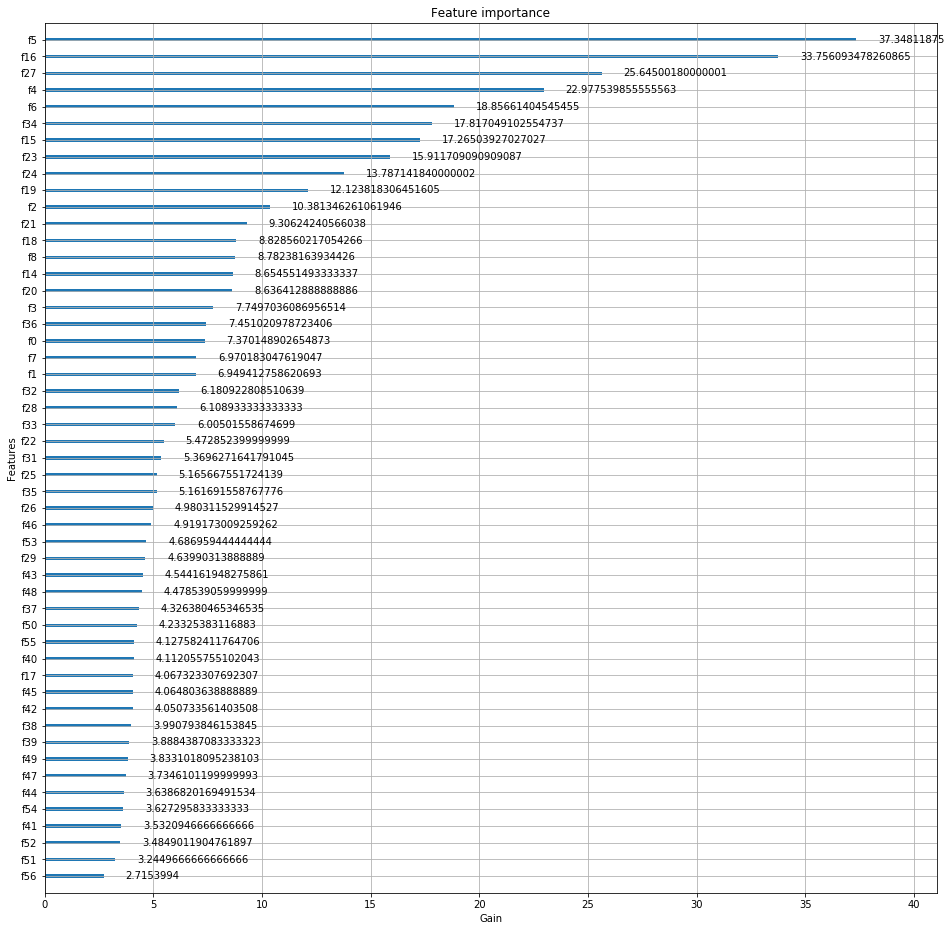

In [77]:
from xgboost import plot_importance

fig, ax = plt.subplots(1,1,figsize=(16, 16))

plot_importance(xgb_model, importance_type='gain', xlabel='Gain', ax=ax)

The features themselves are anonymized but we do know what groups they belong to. The vertical axis of the plot doesn't show the original feature names. When training the XGBoost algorithm, they were automatically renamed according to their index in the input array. 

Manually mapping these indices back to their corresponding feature names shows us that the top five in terms of importance are:
1. 'ps_ind_06_bin'
2. 'ps_ind_17_bin'
3. 'ps_car_07_cat'
4. 'ps_ind_05_cat'
5. 'ps_ind_07_bin'

Curiously, out of the 5 most important features for our trained model, 4 are features that are related to the client as an individual. These could be questions like "have you been in a car accident before?", the gender of the person, the age, etc. We don't know exactly, but even though weather of a region or car model are are probably related to accidents, it does make sense for certain individual characteristics to be highly related to the probability of the client filing a claim or not.

## Results and closing thoughts

The final chosen model is the tuned XGBoost model. The Naïve model had a normalized Gini score of almost 0 and a F-beta score of 0,1095 (beta=1,5 for more focus on recall). The final model did better than logistic regression and XGBoost model without tuning. It managed a normalized Gini of 0,2778 and a F-beta score of 0,6938.  

The XGBoost algorithm was chosen because we are working on a structured tabular dataset which is where XGBoost usually shines. Additionally, it is an algorithm that has proven itself in terms of speed and performance, as we saw earlier. However, after a first round of training right out of the box, the algorithm was tuned and several combinations of parameters were tried. 

Even though we have used the normalized Gini as our principal evaluation metric for this project. The F-beta score played a very important role when choosing the final model. The logistic regression algorithm already obtained a great improvement with respect to the normalized Gini of the benchmark model. From there on, improvements on the normalized Gini were not very large. During parameter tuning there was even a model that performed slightly better on the normalized Gini than the chosen model. 

It is worth remembering that the F-beta score takes into account both precision and recall.  Precision would help us evaluate of how many of the samples classified as filing a claim actually were filed a claim, while recall calculates how many of those that actually filed a claim were classified as such. In this case the F-beta is used with a beta of 1.5 because it can be important for the insurance company to have better recall. In other words, it is important to evaluate out of the drivers that did file a claim how many were correctly classified as such to better adjust the insurance fees.

Coming back to the chosen model, most of the variations were showing very small improvements in terms of normalized Gini. The chosen model did improve with respect to the other models, but at the same time it achieved a F-beta score of almost 0,7 and was therefore chosen. This difference allowed the model to make a jump from 0.266 to 0.270 on Kaggle’s public test set.


Sources:

https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial

https://www.kaggle.com/batzner/gini-coefficient-an-intuitive-explanation

http://shahramabyari.com/2015/12/21/data-preparation-for-predictive-modeling-resolving-skewness/

https://www.kaggle.com/aharless/xgboost-cv-lb-284

https://www.eflglobal.com/every-lender-has-a-gini-coefficient-so-what-exactly-is-it/